In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/weight_vector_simulations_paper/weight_vector_estim_code/

/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [9]:
from algorithm import WeightEstimator

In [10]:
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import multivariate_normal

In [15]:
n_samples = 100

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]


In [16]:
densities =[]
for x in np.linspace(-10,10,20):
    for y in np.linspace(-10,10,20):
        for var in [5, 1, 1e-1]:
            densities.append(multivariate_normal([x,y], var*np.diag([1,1])))

In [13]:
%matplotlib inline

NameError: name 'res' is not defined

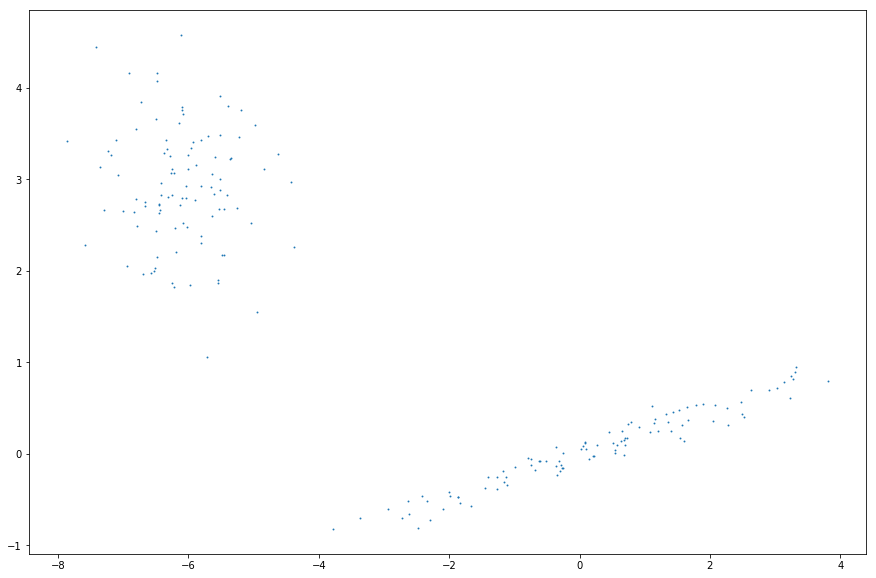

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
splot = plt.subplot(1, 1, 1)

splot.scatter(X[:,0],X[:,1], .8)
for i,_ in res:
    d = densities[i]
    mean, covar = d.mean, d.cov
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [12]:
gmm = GaussianMixture(20)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=20, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [13]:
densities =[]
for mean, var in zip(gmm.means_, gmm.covariances_):
    densities.append(multivariate_normal(mean, var))

In [8]:
cl = WeightEstimator(densities_dict=densities, select_threshold=1e-3)
cl.fit(X)


[ 0.  0.  0. ...,  0.  0.  0.]


In [10]:
cl.pi_final[cl.pi_final > 0]

array([ 0.00315446,  0.08360719,  0.00423585,  0.03617514,  0.15839016,
        0.14192934,  0.07263215,  0.00818737,  0.04433308,  0.06530192,
        0.09671991,  0.12418801,  0.08540385,  0.05481422,  0.02092736])

In [14]:
#On va essayer de faire une grille de l'espace et faire tourner EM et kde sur chaque portion
#pour construire le dictionaire


In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X0 = sc.fit_transform(X)

In [16]:
k_em = 2
x_min, x_max, y_min, y_max = X0[:,0].min(), X0[:,0].max(), X0[:,1].min(), X0[:,1].max()
x_steps = np.linspace(x_min, x_max, grid_length)
y_steps = np.linspace(y_min, y_max, grid_length)
densities_dictionary = []
for grid_length in [5]:
    for idx, x_step in enumerate(x_steps[:-1]):
        for idy, y_step in enumerate(y_steps[:-1]):
            X_temp = X0[(X0[:,0] > x_step) & (X0[:,0] < x_steps[idx+1]) & (X0[:,1] > y_step) & (X0[:,1] < y_steps[idy+1]) ]
            if X_temp.shape[0] > k_em:
                gmm = GaussianMixture(3)
                gmm.fit(X_temp)
                for mean, var in zip(gmm.means_, gmm.covariances_):
                    densities_dictionary.append(multivariate_normal(mean, var))

NameError: name 'grid_length' is not defined

In [ ]:
cl = WeightEstimator(densities_dict=densities_dictionary, select_threshold=1e-10)

In [ ]:
cl.fit(X)

In [ ]:
res = cl.select_densities()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
splot = plt.subplot(1, 1, 1)

splot.scatter(X0[:,0],X0[:,1], .8)
for i,_ in res:
    d = densities_dictionary[i]
    mean, covar = d.mean, d.cov
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [ ]:
best_bic = 1e10
for k in range(2,50):
    gmm = GaussianMixture(k)
    gmm.fit(X0)
    bic = gmm.bic(X0)
    if bic < best_bic:
        best_bic = bic
        score = gmm.score(X0)
        print score
        best_bic_param = (bic, score, gmm.covariances_, gmm.means_, gmm.weights_)
    

In [ ]:
best_bic_param

In [ ]:
densities_em = []
for cov, mean in zip(best_bic_param[2], best_bic_param[3]):
    densities_em.append(multivariate_normal(mean, cov))


In [ ]:
X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
X_grid = np.vstack([X.ravel(), Y.ravel()]).T
X_grid

In [ ]:
def f(x):
    fk = np.array([d.pdf(x) for d in densities_em])
    return best_bic_param[-1].dot(fk)
f_em = np.apply_along_axis(f, 1, X0)
print np.log(f_em).sum()/X0.shape[0]

In [48]:
selected_densities_estim, weights_estim = np.array(zip(*res2))
f_weight_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 1, X0)
log_lik = np.log(f_weight_estim).sum()/X0.shape[0]
log_lik

-54.882235678734169

In [17]:
res

[(218, 0.06889282692661267),
 (221, 0.035466544430183496),
 (277, 0.10231750989867713),
 (278, 0.1456275319223059),
 (281, 0.10825819703086038),
 (338, 0.01906926295800231),
 (449, 0.04082022119365628),
 (509, 0.07447416210326328),
 (569, 0.126301475765866),
 (632, 0.1256061852841631),
 (692, 0.06665509095610522),
 (752, 0.037483876841484486),
 (812, 0.01421875846189462)]

In [17]:
from algorithm import WeightEstimator
cl = WeightEstimator(densities_dict=densities, select_threshold=1e-2)
cl.fit(X)
a = cl.pi_final

In [18]:
cd ../weight_vector_simulations_paper/weight_vector_estim_code/

[Errno 2] No such file or directory: '../weight_vector_simulations_paper/weight_vector_estim_code/'
/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [19]:
F = np.array([densities[i].pdf(X) for i in range(len(densities))]).T

In [20]:
def f0(pi,F):
    return -np.log((pi*F).sum(axis=1)).sum()

In [26]:
from sklearn.mixture import GaussianMixture
def mle_bic(X, kmax):
    best_bic = 1e10
    best_model = None
    for k in range(2,kmax):
        cl = GaussianMixture(n_components=k)
        cl.fit(X)
        bic = cl.bic(X)
        if bic < best_bic:
            best_bic = bic
            best_model = cl
    return best_bic, best_model

(956.66188635617254,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=2, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

In [38]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/phd-clustering-models/tools/

/Users/mehdi/Dropbox/working folder/PHd/phd-clustering-models/tools


In [41]:
from gm_tools import gaussian_mixture_sample, gm_params_generator, best_cont_matrix
weights, centers, cov = gm_params_generator(2,5)
X, Y = gaussian_mixture_sample(weights, centers, cov, 1000)

In [42]:
mle_bic(X,15)

(-3015.5472245981714,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=5, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

In [47]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/weight_vector_simulations_paper/weight_vector_estim_code/

/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [48]:
from DensitiesGenerator import DensityGenerator

In [49]:
dg = DensityGenerator(n_pdf= 1000)

In [58]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import laplace
from scipy.integrate import simps
nodes_gauss = [0, 0.2, 0.4, 0.6, 0.8, 1]
var_list = [1, 10**(-1), 10**(-2), 10**(-3)]
densities = []
for m in nodes_gauss:
    for var in var_list:
        densities.append(multivariate_normal(m, var))
scales =[0.05, 0.1, 0.2, 0.5, 1]
nodes_lapl = [0, 0.2, 0.4, 0.6, 0.8, 1]
for m in nodes_lapl:
    for scale in scales:
        densities.append(laplace(loc=m, scale=scale))
X = dg.generate_uniform(n_points=100)


In [63]:
Y = X[0].reshape(-1,1)

In [64]:
mle_bic(Y,15)

(47.474573931065919,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=3, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

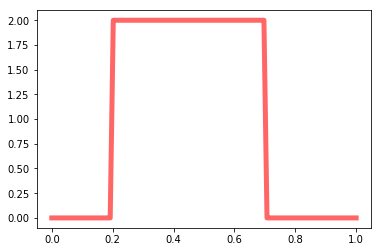

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import uniform
rv = uniform(0.2,0.5)
x = np.linspace(0,1, 100)
plt.plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label='uniform pdf')

In [150]:
densities = []
for i in range(50):
        densities.append(uniform_nonzero(i*1./50,1./50))

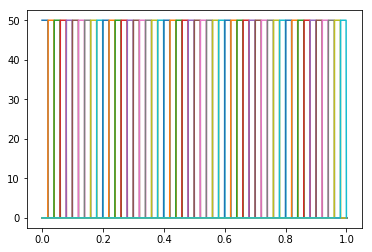

In [151]:
x = np.linspace(0, 1, 1000)
for d in densities:
    plt.plot(x, d.pdf(x))

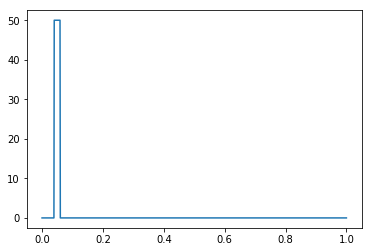

In [152]:
plt.plot(x, densities[2].pdf(x))

# Generation du dictionnaire

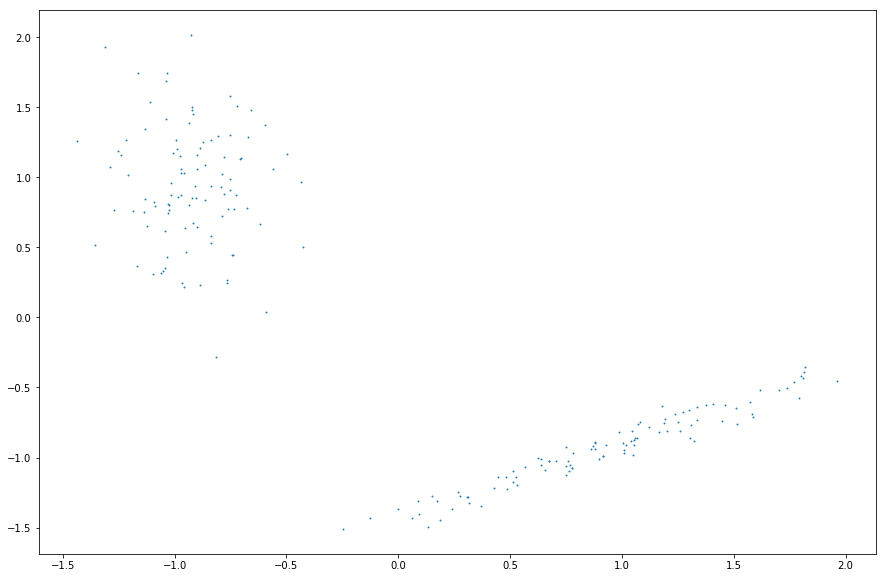

In [17]:
X = sc.fit_transform(X)
plt.scatter(X[:,0],X[:,1], .8)

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [19]:
pc = PCA(2)
sc = StandardScaler()

In [31]:
X_pca = pc.fit_transform(sc.fit_transform(X))
pc.components_

array([[-0.70710678,  0.70710678],
       [-0.70710678, -0.70710678]])

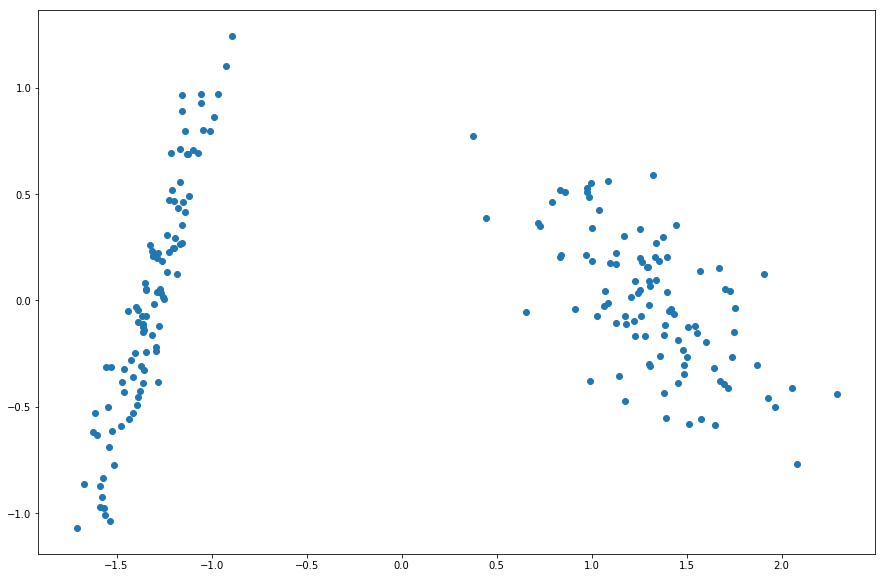

In [32]:
plt.scatter(X_pca[:,0], X_pca[:,1])

In [22]:
from sklearn.cluster import KMeans
km = KMeans(5)
X_temp0= km.fit_predict(X_pca[:,0].reshape(-1,1))
X_temp1= km.fit_predict(X_pca[:,1].reshape(-1,1))

In [23]:
X_temp1[0]

2

In [43]:
kmeans = KMeans(2)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
y = kmeans.labels_

In [51]:
y[np.where(y==1)]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [122]:
cd ../tools/

/Users/mehdi/Dropbox/working folder/PHd/phd-clustering-models/tools


In [159]:
from gm_tools import gaussian_mixture_sample, gm_params_generator, best_cont_matrix
weights, centers, cov = gm_params_generator(10,3)
X, Y = gaussian_mixture_sample(weights, centers, cov, 1000)

In [160]:
X

array([[ 0.03717608, -1.15220815, -0.63477926, ...,  1.30554143,
         2.22423824,  1.51622318],
       [-0.07206821, -0.91839595, -0.62778374, ...,  1.43750006,
         2.33168   ,  1.69296087],
       [ 1.47955317, -1.10682111, -2.62963366, ...,  0.3303743 ,
         2.13341828, -0.6861456 ],
       ..., 
       [-0.43803426, -1.28543693, -0.91326653, ...,  0.9660687 ,
         1.85596215,  1.45977998],
       [-0.43260847, -1.55075385, -0.80510266, ...,  1.07989485,
         1.7797362 ,  1.39173138],
       [-0.26803614, -1.35060715, -0.89429421, ...,  1.06051135,
         1.72468985,  1.45074475]])

In [167]:
dg = DictionaryGenerator(max_pca_comp=5)

In [168]:
dg.fit(X )
dg.densities

[[<scipy.stats._multivariate.multivariate_normal_frozen at 0x1146ec4d0>,

In [79]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(2)
gm.fit(X)
gm.covariances_

array([[[ 0.03863992, -0.0073086 ],
        [-0.0073086 ,  0.17751361]],

       [[ 0.25322626,  0.13426231],
        [ 0.13426231,  0.07563479]]])

In [173]:
import pypmc

In [181]:
from pypmc.sampler.importance_sampling import ImportanceSampler


In [175]:
for i in range(X.shape[1]):
    print X[:,i].min(), X[:,i].max()

-2.68449893153 1.9113202268
-1.88855044146 1.60213288427
-2.74197546065 -0.32963205798
-2.81993508036 2.55187166683
-2.01797346592 1.08148826271
-2.48619196342 0.0539009970857
-2.75843006585 0.557241085456
-2.48493987178 1.6740202351
1.29569806977 2.64557118809
-1.73689129564 1.95689548016


In [176]:
from pypmc.tools.indicator import merge_function_with_indicator

# define indicator
ind_lower = [-3 for _ in range(X.shape[1])]
ind_upper = [3 for _ in range(X.shape[1])]
ind = pypmc.tools.indicator.hyperrectangle(ind_lower, ind_upper)


In [276]:
from pypmc.density.mixture import create_gaussian_mixture

def binary_centers(K,p):
    if K > 2**p:
        print "Warning: not enough nodes"
        K_ = 2**p
    else:
        K_ = K
    centers = []
    for i in range(K_):
        bin_array = list(bin(i).split("b")[1])
        zeros_arr = [0]*(p-len(bin_array))
        centers.append(np.array(map(int, zeros_arr+bin_array)))
    return np.array(centers)

def generate_gaussian_mixture_sample(N, p, weights):
    K = len(weights)
    centers = binary_centers(K, p)
    cov = np.array([1e-2*np.diag(np.ones(p)) for _ in range(K)])
    mixture = create_gaussian_mixture(centers, cov, weights)
    return mixture.propose(N)
        

In [187]:
y = np.ma.array([1, 2, 3], mask = [0, 1, 0])

masked_array(data = [1 -- 3],
             mask = [False  True False],
       fill_value = 999999)

In [238]:
np.diag(np.ones(5))

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [234]:
binary_centers(50,22)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [286]:
K = 4
5
N = 1000
p = 3
weights = 1./K*np.ones(K)
X2 = sc.fit_transform(generate_gaussian_mixture_sample(N, p, weights))

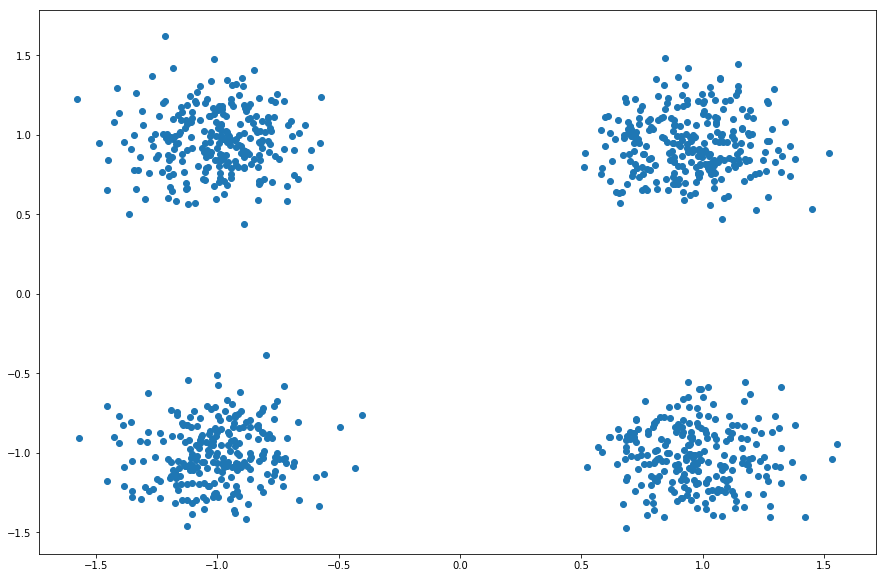

In [287]:
plt.scatter(X2[:,1], X2[:,2])